In [2]:
from utils import *
from tqdm.auto import tqdm
from SALib.analyze import pawn
import numpy as np
import pickle
import time
import os

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.patches as patches
from matplotlib.colors import Normalize
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": False, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [3]:
problem = {
    'num_vars': 6,
    'names': ["alpha", "invest_cost", "health_delta", "prob_health_decrease", "prob_health_increase", "gamma"],
    'bounds': [[0, 1], [1, 10], [1, 10], [0,1], [0,1], [0.4,0.8]]
}

### Sen's Welfare Function

In [6]:
def gini(data):
    if len(data) == 0:
        return 0
    data = np.asarray(data)
    data = np.sort(data)
    n = len(data)
    index = np.arange(1, n + 1)  # 1-based index
    gini = (2 * np.sum(index * data)) / (n * np.sum(data)) - (n + 1) / n
    return gini

def sen_welfare(data):
    return np.mean(data) * (1-gini(data))

In [7]:
time.sleep(500)

In [8]:
result_dir = "results"
sen_results = []
for f in tqdm(os.listdir(result_dir)):
    with open(os.path.join(result_dir, f), "rb") as f:
        res = pickle.load(f)
    wealth = res["wealth"]
    health = res["health"]
    util = utility(res["wealth"], res["health"], alpha=res['params']['alpha'])
    sen_results.append(
        (res["params"], sen_welfare(util[:,-1]))
    )

with open("sen_welfare.pickle", "wb") as f:
    pickle.dump(sen_results, f)

  0%|          | 0/512 [00:00<?, ?it/s]

In [9]:
with open("sen_welfare.pickle", "rb") as f:
    sen_results = pickle.load(f)

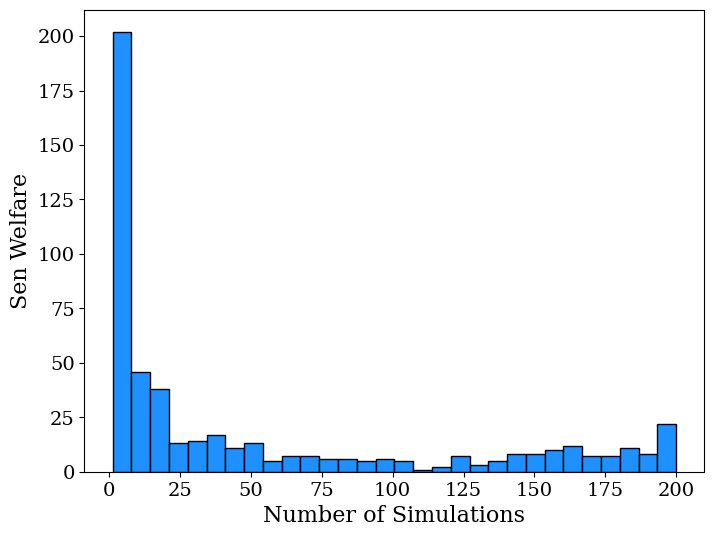

In [10]:
plt.hist(
    [t[1] for t in sen_results],
    bins=30,
    color="dodgerblue",
    edgecolor="k"
)
plt.ylabel("Sen Welfare")
plt.xlabel("Number of Simulations")
plt.show()

In [11]:
X = []
Y = []
for t in sen_results:
    X.append((t[0]["alpha"], t[0]["invest_cost"], t[0]["health_delta"], t[0]["P_H_decrease"], t[0]["P_H_increase"], t[0]["gamma"]))
    Y.append(t[1])

X = np.array(X)
Y = np.array(Y)

In [12]:
pawn.analyze(problem, X, Y, S=10, print_to_console=False)

/Users/charlesdupont/Documents/code/wealth-health/.venv/lib/python3.13/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


{'minimum': array([0.20454197, 0.08612898, 0.09750306, 0.09068627, 0.06652114,
        0.07950368]),
 'mean': array([0.38984522, 0.13844439, 0.1617994 , 0.21590633, 0.11382241,
        0.11691913]),
 'median': array([0.37251072, 0.11253005, 0.15540748, 0.20561428, 0.10472197,
        0.11956189]),
 'maximum': array([0.58758425, 0.24869792, 0.2351262 , 0.51472356, 0.17535999,
        0.14793964]),
 'CV': array([0.29188204, 0.37060427, 0.27836442, 0.52617692, 0.30482538,
        0.165593  ]),
 'names': ['alpha',
  'invest_cost',
  'health_delta',
  'prob_health_decrease',
  'prob_health_increase',
  'gamma']}

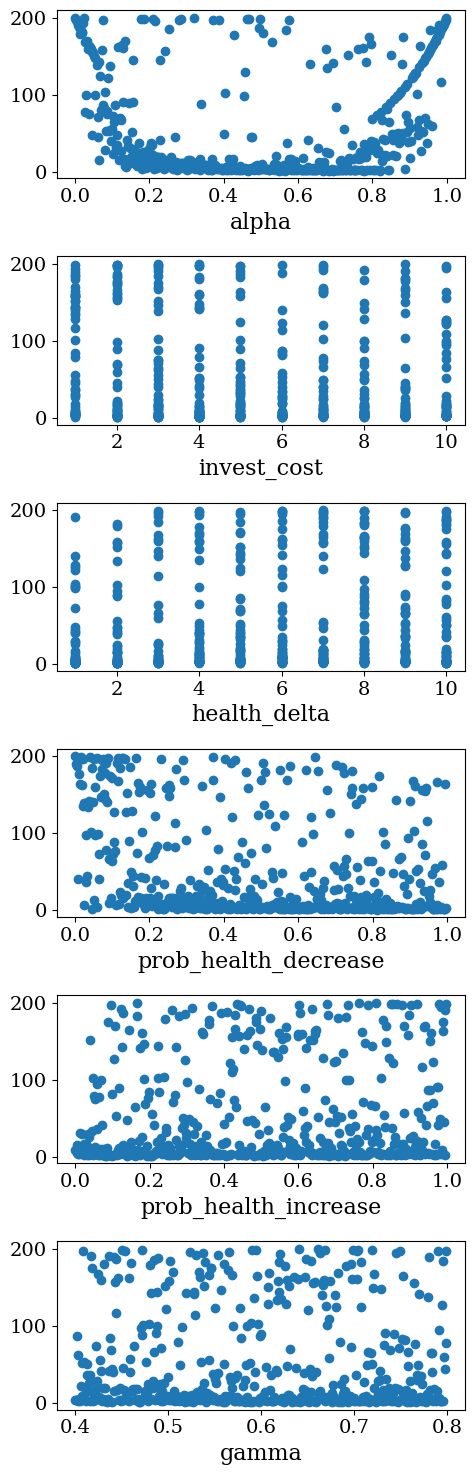

In [13]:
num_vars = problem["num_vars"]
fig, axs = plt.subplots(num_vars, 1, figsize=(5,15))
for idx in range(num_vars):
    axs[idx].scatter(
        X[:,idx],
        Y,
    )
    axs[idx].set_xlabel(problem["names"][idx])
fig.tight_layout()
plt.show()

### MFPT

In [14]:
result_dir = "results"

interpolation_functions = []

for f in tqdm(os.listdir(result_dir)):
    with open(os.path.join(result_dir, f), "rb") as f:
        res = pickle.load(f)
    wealth = res["wealth"]
    health = res["health"]
    
    interp_func = get_interpolation_function(
        res["wealth"][:,-1],
        res["health"][:,-1]
    )

    interpolation_functions.append(
        (res["params"], interp_func)
    )

with open("interpolation_functions.pickle", "wb") as f:
    pickle.dump(interpolation_functions, f)

  0%|          | 0/512 [00:00<?, ?it/s]

In [15]:
with open("interpolation_functions.pickle", "rb") as f:
    interpolation_functions = pickle.load(f)

MINIMA = []
for param_set, func in tqdm(interpolation_functions):
    MINIMA.append(
        (param_set, get_minima(func, count_threshold=2, num_points=15, N=param_set["N"], step_size=20))
    )

with open("mninima.pickle", "wb") as f:
    pickle.dump(MINIMA, f)

  0%|          | 0/512 [00:00<?, ?it/s]